In [12]:
!pip install livelossplot;
!pip install torchsummary;
!pip install torchvision;
import math;
from inspect import isfunction;
from functools import partial;

%matplotlib inline
import matplotlib.pyplot as plt;
#from einops import rearrange

import torch;
import torch.nn as nn;
import torch.nn.functional as F;
import torchvision;
import numpy as np;
from torchvision import transforms;
from livelossplot import PlotLosses;
from torchvision import transforms;
from torchvision.utils import make_grid;


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\20210826\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\20210826\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\20210826\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [196]:
import math
import random
from inspect import isfunction
from functools import partial

# %matplotlib inline
# import matplotlib.pyplot as plt
# from tqdm.auto import tqdm
# from einops import rearrange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
from torchvision import transforms

# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html

class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels: int,
                 base_channel_size: int,
                 latent_dim: int):
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
            nn.GELU(),
            nn.Flatten(),
            nn.Linear(2 * 16 * c_hid, latent_dim)
        )

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels: int,
                 base_channel_size: int,
                 latent_dim: int):
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2 * 16 * c_hid),
            nn.GELU()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.GELU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=0),
            nn.GELU(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.to(torch.float32)  # because linear layer expects float32
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x


"""
encoder = Encoder(num_input_channels=1, base_channel_size=32, latent_dim=256)
# input image
x = torch.randn(10000, 1, 28, 28)
encoder(x).shape
decoder = Decoder(num_input_channels=1, base_channel_size=32, latent_dim=256)
# input image
x = torch.randn(1000, 256)
decoder(x).shape
"""


# Measures the reconstruction loss from the encoding the image to latent space and then decoding it back to the image
def autoencoder_loss(x, x_hat):
    return F.binary_cross_entropy(x_hat, x)  # For MNIST dataset (or log prob if we get distributions)


# Latent loss
def latent_loss(x_hat):
    var_1 = sigma2(gamma(x_hat))
    mean1_sqr = (1.0 - var_1) * torch.square(x_hat)
    loss_lat = 0.5 * (mean1_sqr + var_1 - np.log(var_1) - 1.0)
    return loss_lat


def recon_loss(img, enc_img, decoder: Decoder):
    g_0 = gamma(0)
    # numpy normal distribution
    eps_0 = np.random.normal(size=enc_img.size())
    z_0 = variance_map(enc_img, g_0, eps_0)
    # rescale
    z_0_rescaled = z_0 / alpha(g_0)
    # decode
    decoded_img = decoder(z_0_rescaled)
    # make sure decoded_img is positive (change tensor sign)
    decoded_img = torch.where(decoded_img < 0, -decoded_img, decoded_img)  # this might be a bottleneck
    return autoencoder_loss(img, decoded_img)


############################################################################################################
# Diffusion process functions
############################################################################################################
# The timestep embedding is for the diffusion model to learn the temporal information of the time series
def get_timestep_embedding(timesteps, embedding_dim):
    timesteps *= 1000
    half_dim = embedding_dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim) * -emb)
    emb = np.outer(timesteps, emb)
    emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)

    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return torch.from_numpy(emb).float()


# Forward diffusion process functions
def gamma(ts, gamma_min=-6, gamma_max=6):
    return gamma_max + (gamma_min - gamma_max) * ts


def sigma2(gamma_x):
    tensor = torch.tensor(gamma_x)
    return torch.sigmoid(-tensor)  # correct?


def alpha(gamma_x):
    return np.sqrt(1 - sigma2(gamma_x))


def variance_map(x, gamma_x, eps):
    return alpha(gamma_x) * x + np.sqrt(sigma2(gamma_x)) * eps


class ResNet(nn.Module):
    # Residual network
    def __init__(self, latent_dim, embed_dim, num_blocks=4, num_layers=10, activation=nn.ReLU, norm=nn.LayerNorm):
        super().__init__()
        self.latent_dim = latent_dim
        self.embed_dim = embed_dim
        self.num_blocks = num_blocks
        self.num_layers = num_layers
        self.activation = activation
        self.norm = norm

        self.blocks = nn.ModuleList()
        for _ in range(self.num_layers):
            self.blocks.append(self._make_block())

    def _make_block(self):
        # without convolutional layers
        layers = [self.norm([self.latent_dim]), self.activation(), nn.Linear(self.latent_dim, self.embed_dim)]
        return nn.Sequential(*layers)

    def forward(self, x, cond):
        z = x
        for block in self.blocks:
            h = block(z)
            if cond is not None:
                h = h + nn.Linear(cond.shape[1], self.embed_dim, bias=False)(cond)
            h = self.activation()(self.norm([self.embed_dim])(h))
            h = nn.Linear(self.embed_dim, self.latent_dim)(h)
        z = z + h
        return z


# Score neural network for the diffusion process. Approximates what you should do at each timestep
class ScoreNet(nn.Module):
    def __init__(self, latent_dim, embedding_dim, n_blocks=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.embedding_dim = embedding_dim
        self.resnet = ResNet(self.embedding_dim, self.embedding_dim * 2)

    def forward(self, x, t, conditioning):
        timestep = get_timestep_embedding(t, self.embedding_dim)
        # assert conditioning.shape[0]==timestep.shape[0] #as the output of encoder is (1, encoded_dim) this condition must eb satisfied
        cond = timestep  # cond = torch.cat((timestep, conditioning), dim=1)

        cond = nn.SiLU()(nn.Linear(self.embedding_dim, self.embedding_dim * 4)(cond))
        cond = nn.SiLU()(nn.Linear(self.embedding_dim * 4, self.embedding_dim * 4)(cond))
        cond = nn.Linear(self.embedding_dim * 4, self.embedding_dim)(cond)

        h = nn.Linear(self.latent_dim, self.embedding_dim)(x)  # hardcoded but should be latent_dim
        #h = torch.reshape(h, (1, 32, 1, 1))  # Reshaped for convolutional layers
        h = self.resnet(h, cond)
        return x + h


def diffusion_loss(z_0, t, score_net, conditioning):
    # z_0 is the initial latent variable
    # t is the time step (time steps need to be discrete)
    # z_t is the latent variable at time t
    # z_t is a function of z_0 and t

    eps = torch.randn_like(z_0)
    gamma_x = gamma(t)
    z_t = variance_map(z_0, gamma_x, eps)

    # The score function is the derivative of the latent variable with respect to time
    score = score_net(z_t, t, conditioning)
    loss_diff_mse = torch.mean((score - z_t) ** 2)

    # The diffusion process is a stochastic process
    T = len(t)
    s = t - (1. / T)
    g_s = gamma(s)
    loss_diff = .5 * np.expm1(g_s - gamma_x) * loss_diff_mse

    return loss_diff


class VariationalDiffusion(nn.Module):
    timesteps: int = 1000
    layers: int = 32
    gamma_min: float = -3.0
    gamma_max: float = 3.0

    def __init__(self, latent_dim, embedding_dim, n_blocks=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.embedding_dim = embedding_dim
        self.score_net = ScoreNet(self.latent_dim, self.embedding_dim, n_blocks=n_blocks)
        self.encoder = Encoder(1, 32, latent_dim)
        self.decoder = Decoder(1, 32, latent_dim)

    def forward(self, img, conditioning=None):  # combined loss for diffusion and reconstruction
        # encoding image
        z_0 = self.encoder(img)
        # encoder loss
        loss_recon, recon_IMG = recon_loss(img, z_0, self.decoder)

        loss_latent = latent_loss(z_0)

        # diffusion loss
        # we need to sample time steps
        t = torch.rand((z_0.shape[0], 1))
        # discretize time steps
        t = np.ceil(t * self.timesteps)
        loss_diff = diffusion_loss(z_0, t, self.score_net, conditioning, self.timesteps)
        return (torch.mean(loss_recon) + torch.mean(loss_latent) + torch.mean(loss_diff))/(torch.prod(torch.tensor(img.shape[1:]))*np.log(2)),  (torch.mean(loss_recon), torch.mean(loss_latent), torch.mean(loss_diff)/(torch.prod(torch.tensor(img.shape[1:]))*np.log(2))), recon_IMG

    def sample(self, z, t, conditioning, num_samples=1):
        eps = torch.randn((num_samples, self.latent_dim))
        gamma_x = gamma(t)
        z_t = variance_map(eps, gamma_x, eps)
        score = self.score_net(z_t, t, conditioning)
        return z_t + score

    def sample_from_prior(self, t, num_samples=1):
        return self.sample(t, conditioning=torch.zeros((num_samples, 0)), num_samples=num_samples)

    def sample_from_posterior(self, t, conditioning, num_samples=1):
        return self.sample(t, conditioning=conditioning, num_samples=num_samples)
def TrainVDM(batch_size_train, n_epochs):
    
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../', train=True, download=False,
                                transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor()
                                ])),batch_size=batch_size_train, shuffle=True)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model=VariationalDiffusion(256, 256).to(device)    
    model.train()
    log_interval=50
    train_losses = []
    train_counter = []
    logs={}
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.008, weight_decay=1e-4)
    for epoch in range(1, n_epochs + 1):
        for batch_idx, (data, target) in enumerate(train_loader):
            
            optimizer.zero_grad()
            loss, values, IMG = model(data)
            #print(values)
            loss.backward()
            optimizer.step()

            
            #logs['loss'] = np.array(train_losses)
            #liveloss.update(logs)
            #liveloss.draw()
            plt.plot(train_losses)
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f},{}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),values))
                train_losses.append(loss.item())
                train_counter.append(
                (batch_idx*1000) + ((epoch-1)*len(train_loader.dataset)))
                
        
if __name__ == "__main__":
    # model
    model = VariationalDiffusion(latent_dim=128, embedding_dim=128)
    # a random image 28x28x1
    img = torch.randn(1, 1, 28, 28)
    # loss, values, IMG = model(img)
    # img=torchvision.utils.make_grid(IMG, 5, 0)
    # print(img.shape, img.shape)
    # plt.imshow( np.transpose(img.numpy(), (1, 2, 0)))


C:\Users\20210826\AppData\Local\Temp\ipykernel_11564\2898123643.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(gamma_x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 120.419563,(tensor(0.1398, grad_fn=<MeanBackward0>), tensor(0.0005, grad_fn=<MeanBackward0>), tensor(120.4193, grad_fn=<DivBackward0>))
Train Epoch: 1 [25600/60000 (42%)]	Loss: 91.258972,(tensor(0.0893, grad_fn=<MeanBackward0>), tensor(0.9838, grad_fn=<MeanBackward0>), tensor(91.2570, grad_fn=<DivBackward0>))
Train Epoch: 1 [51200/60000 (85%)]	Loss: 87.576263,(tensor(0.0713, grad_fn=<MeanBackward0>), tensor(0.0025, grad_fn=<MeanBackward0>), tensor(87.5761, grad_fn=<DivBackward0>))
Train Epoch: 2 [0/60000 (0%)]	Loss: 86.129929,(tensor(0.0688, grad_fn=<MeanBackward0>), tensor(0.0033, grad_fn=<MeanBackward0>), tensor(86.1298, grad_fn=<DivBackward0>))
Train Epoch: 2 [25600/60000 (42%)]	Loss: 83.075729,(tensor(0.0663, grad_fn=<MeanBackward0>), tensor(0.0036, grad_fn=<MeanBackward0>), tensor(83.0756, grad_fn=<DivBackward0>))
Train Epoch: 2 [51200/60000 (85%)]	Loss: 82.521843,(tensor(0.0687, grad_fn=<MeanBackward0>), tensor(0.0038, grad_fn=<MeanBackward0>),

KeyboardInterrupt: 

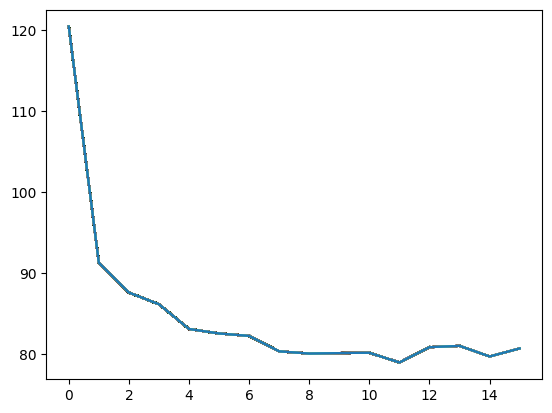

In [197]:
TrainVDM(512, 23)
torch.save(model.state_dict(), "./MODEL...ef")

In [177]:
VDM= VariationalDiffusion(256, 256)
VDM.load_state_dict(torch.load( "./MODEL_new_loss"))

<All keys matched successfully>

torch.Size([5, 1, 28, 28])
torch.Size([5, 1, 28, 28])
(tensor(0.1300), tensor(0.0003), tensor(0.3103))
tensor(0.)
torch.Size([3, 84, 28]) torch.Size([3, 84, 28])


C:\Users\20210826\AppData\Local\Temp\ipykernel_11564\155385523.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(gamma_x)


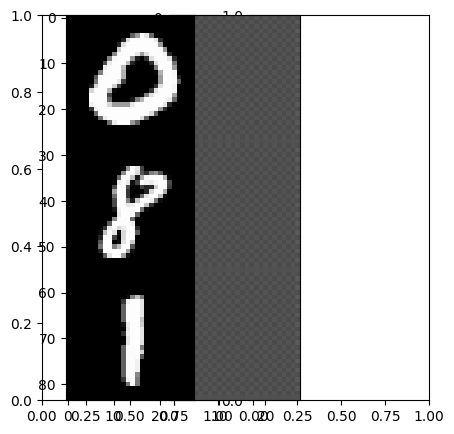

In [190]:
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('../', train=False, download=False,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
                            ])),batch_size=5, shuffle=True)
#(0.1307,), (0.3081,)
#tf.random.uniform(image.shape) < image / 255.0
def test(test_loader, VDM):
    #batch=torch.empty((10,1,28,28), dtype=torch.int64)
    VDM.eval()
    with torch.no_grad():
        data, target = next(iter(test_loader))
        print(data.shape)
        loss, ind_loss, output = VDM(data)
        print(output.shape)
        print(ind_loss)
        print(data[1].min())
    fig, ax = plt.subplots(1,2,figsize=(5,5))
    global img, img_in
    img=torchvision.utils.make_grid(output[:3], 1, 0)
    img_in=torchvision.utils.make_grid(data[:3], 1, 0)
    fig.add_subplot(1, 1, 1)
    print(img_in.shape, img.shape)
    plt.imshow( np.transpose(img.numpy(), (1, 2, 0)))
    fig.add_subplot(1, 2, 1)
    plt.imshow( np.transpose(img_in.numpy(), (1, 2, 0))) 
    plt.show
test(test_loader,VDM)
#loss_recon, loss_latent, loss_diff
#loss_recon should be highest

In [129]:
test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('../', train=False, download=False,transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
                            ])),batch_size=10, shuffle=True)
data, target = next(iter(test_loader))
data.min()

tensor(0.)